In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spst

from statsmodels.base.model import GenericLikelihoodModel
from statsmodels.tools.tools import add_constant
from statsmodels.formula.api import poisson, negativebinomial

import warnings
warnings.filterwarnings('ignore')

# Setup

In this problem, we will look at a dataset from [NYC OpenData](https://data.cityofnewyork.us/City-Government/Parking-Violations-Issued-Fiscal-Year-2014/jt7v-77mi). This dataset reports the number of parking violations issued in two boroughs of NYC on a given day. The columns of this dataset are as follows:

* **`StreetCode1`**, **`StreetCode2`**, **`StreetCode3`**. These three columns together serve as an identifier for where the ticket was issued.

* **`Violation County`**:  This identifies the borough where the ticket was issued. "BX" stands for the Bronx, and "K" stands for Brooklyn.

* **`NViolations`**: This identifies how many tickets were issued in the area. Note that all entries have at least 1 violation; in other words, only areas with at least 1 violation are recorded.

In [2]:
data = pd.read_csv('Parking_violation_Unit.csv')
data.head()

,StreetCode1,StreetCode2,StreetCode3,Violation County,NViolations
0,0,9980,0,K,1
1,0,12140,0,BX,1
2,0,13430,0,K,1
3,0,26820,0,BX,1
4,0,28410,0,BX,1


# Part 1 [6 pts]

One way to account for the lack of data with 0 counts is to modify the likelihood of each observation used to compute MLE. The  **zero-truncated** likelihood of $y_i$ is

$$\frac{P(y_i)}{P(y>0)} = \frac{P(y_i)}{1-P(y=0)} = \frac{PMF_{Poisson}(y_i|\lambda)}{1-PMF_{Poisson}(y=0|\lambda)}.$$

This proportionally changes the likelihood everywhere so that $y=0$ is accounted for.

Perform the following tasks:

* Define a new column **Brooklyn**, which takes on value 1 if **Violation County** is K and 0 if **Violation County** is BX.

* Estimate a Poisson model by regressing **NViolations** on **Brooklyn** using the zero-truncated likelihood. You will need to define a new `GenericLikelihoodModel` that computes the likelihood above.

* Show the summary of the model.

In [3]:
# I'm running everything locally
print(data['Violation County'].unique())
# so we check if Violation County only have the two situations as mentioned, K and BX

['K' 'BX']


In [4]:
data['Brooklyn'] = data['Violation County'].apply(lambda x: 1 if x == 'K' else 0)
data.head()

,StreetCode1,StreetCode2,StreetCode3,Violation County,NViolations,Brooklyn
0,0,9980,0,K,1,1
1,0,12140,0,BX,1,0
2,0,13430,0,K,1,1
3,0,26820,0,BX,1,0
4,0,28410,0,BX,1,0


In [5]:
# mimic codes from lecture
class PoissonMix(GenericLikelihoodModel):
    def loglike(self, params):
        X, y = self.exog, self.endog
        lambda1 = np.exp(np.dot(X, params))
        pmfy = spst.poisson.pmf(y,lambda1)
        pmf0 = spst.poisson.pmf(0,lambda1)
        ztl = pmfy/(1-pmf0)
        ll = np.log(ztl)
        # Same as log1 - log2.
        
        return np.sum(ll)

In [6]:
X = data['Brooklyn']
X = add_constant(X)
Model1 = PoissonMix(data['NViolations'], X).fit()

Optimization terminated successfully.
         Current function value: 1.111589
         Iterations: 34
         Function evaluations: 68


In [7]:
print(Model1.summary())

                              PoissonMix Results                              
Dep. Variable:            NViolations   Log-Likelihood:                -1757.4
Model:                     PoissonMix   AIC:                             3519.
Method:            Maximum Likelihood   BIC:                             3530.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:03:48                                         
No. Observations:                1581                                         
Df Residuals:                    1579                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2650      0.069     -3.828      0.000      -0.401      -0.129
Brooklyn       0.1490      0.079      1.876      0.0

# Part 2 [8 pts]

Perform the following tasks using your estimated model. For all analyses, we will only be looking at areas in Brooklyn (**Brooklyn** $=1$).

* Use a bar chart to plot the PMF of the model that you estimated over the range 0 to 10. Compute $E(y)$.

* Use a bar chart to plot the conditional distribution $P(y|y>0)$. In other words, these are the zero-truncated likelihoods. Numerically compute $E(y|y>0)$ (hint: recall the basic definition of expectation of a discrete distribution).

* Which probabilities are larger for $y \neq 0$, $P(y)$ or $P(y|y>0)$? Give a brief, intuitive explanation for your observations.


In [8]:
Model1.params

array([-0.2649888 ,  0.14899973])

In [9]:
beta0, beta1=Model1.params
print(beta0, beta1)
lambdaB = np.exp(beta0+beta1)
y_list = np.arange(0, 11) # range 0 to 10
pmfyHere = spst.poisson.pmf(y_list, lambdaB)

-0.26498880339534786 0.14899972999977434


In [10]:
print(lambdaB)
print('E(y): ', np.sum(y_list * pmfyHere))

0.8904849532211466
E(y):  0.8904849188822807


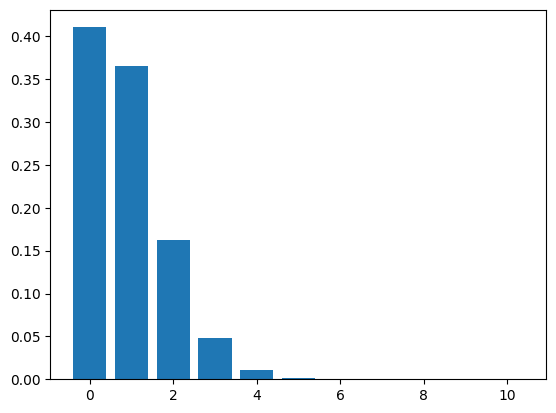

In [11]:
plt.bar(y_list, pmfyHere)
plt.show()

In [12]:
pmfyHere

array([4.10456652e-01, 3.65505473e-01, 1.62738562e-01, 4.83054136e-02,
       1.07538110e-02, 1.91522137e-03, 2.84245969e-04, 3.61595370e-05,
       4.02494045e-06, 3.98238767e-07, 3.54625630e-08])

In [13]:
pmfTL = pmfyHere[1:] / (1-pmfyHere[0]) 
# I understand this question is telling us starting we should apply the function for y>0 so doing [1:]

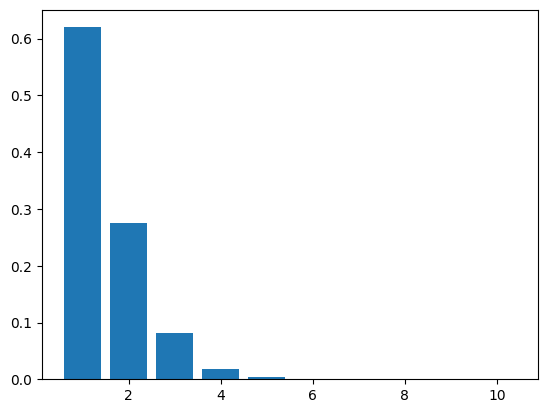

In [14]:
plt.bar(y_list[1:], pmfTL) # As we want for y > 0
plt.show()

In [15]:
print('E(y|y>0): ', np.sum(y_list[1:] * pmfTL))

E(y|y>0):  1.5104655530597226


We can see for our case here, $P(y|y>0)$ is larger. Probably because for $P(y|y>0)$, the total probability mass is distributed over y > 0, thus increased each P (for y > 0). (Or that is we excludes case for y = 0 here, normalizing the distribution over y > 0 would thus gives larger P.) Better for cases with the missing observation of 0.

# Part 3 [8 pts]

Let's now estimate a NBD model using zero-truncated likelihoods. Again, you will need to define a new `GenericLikelihoodModel` that computes the likelihood as defined in Part 1, this time using the PMF of the negative binomial distribution rather than Poisson.

After estimating the model:

* Show the summary along with appropriate names for the parameters.

* Compute and print $E(y)$ for areas in Brooklyn. How does $E(y)$ for the NBD model compare to $E(y)$ for the Poisson model?



In [16]:
class NBDZeroTruncated(GenericLikelihoodModel):
    def loglike(self, params):
        X, y = self.exog, self.endog
        gamma = np.exp(params[0])
        alpha = np.exp(params[1]) / np.exp(X@params[2:])
        pmfy = spst.nbinom.logpmf(y, n=gamma, p=alpha/(1+alpha))
        pmf0 = spst.nbinom.pmf(0, n=gamma, p=alpha/(1+alpha))
        ll = pmfy - np.log(1 - pmf0)
        
        return np.sum(ll)

In [17]:
X = data['Brooklyn']
Model3 = NBDZeroTruncated(data['NViolations'], X).fit(start_params=np.zeros(3), method="bfgs")
print(Model3.summary(xname=["log_gamma", "log_alpha", "Brooklyn"]))

         Current function value: 0.901288
         Iterations: 26
         Function evaluations: 66
         Gradient evaluations: 55
                           NBDZeroTruncated Results                           
Dep. Variable:            NViolations   Log-Likelihood:                -1424.9
Model:               NBDZeroTruncated   AIC:                             2854.
Method:            Maximum Likelihood   BIC:                             2865.
Date:                Mon, 11 Nov 2024                                         
Time:                        15:03:49                                         
No. Observations:                1581                                         
Df Residuals:                    1580                                         
Df Model:                           0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [18]:
print(Model3.params)

[-11.38646967   0.02729484   0.18487183]


In [20]:
gammahat = np.exp(Model3.params[0])
alphahat = np.exp(Model3.params[1])
print(gammahat / (alphahat / np.exp(Model3.params[2])))

1.3284764937612022e-05


We can see the E(y) for the NBD model is much smaller than the E(y) for the Poisson model. (assuming we're only asked to compare which one is larger)

# Part 4 [8 pts]

Perform the following tasks using your estimated model. For all analyses, we will only be looking at areas in Brooklyn (**Brooklyn** $=1$).

* Overlay two line plots on one figure showing the distributions of the following over the range 0 to 10: a) $P(\hat\lambda|y=5)$, the likelihoods of $\hat\lambda$ conditioning on observing 5 violations, and b) $P(\hat\lambda|y=5,y=1)$, the likelihoods of $\hat\lambda$ conditioning on observing 5 violations followed by another observation of 1 violation. Please provide a legend to label each plot.

* Compute and print out the expectations a) $E(\hat \lambda|y=5)$, and b) $E(\hat \lambda|y=5,y=1)$. Briefly explain how the expectations change with each new observation, starting from $E(\hat\lambda)$ (no observations).

* Display a bar chart showing the PMF of the number of violations given the two observations above: $P(\hat y | y=5,y=1)$.

E(lambda|y=5) = 2.696570800568614
E(lambda|y=5,y=1) = 2.102161075108111


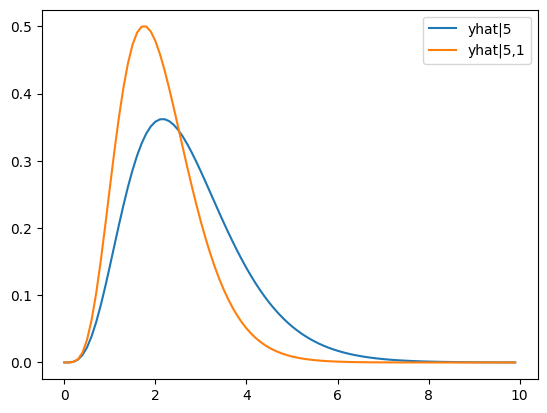

In [21]:
alphahat_i = alphahat / np.exp(Model3.params[2])
xvalues = np.arange(0,10,.1)

gammahat += 5
alphahat_i += 1
print("E(lambda|y=5) =", gammahat/alphahat_i)
plt.plot(xvalues, spst.gamma.pdf(xvalues, a=gammahat, scale=1/alphahat_i), label='yhat|5')

gammahat += 1
alphahat_i += 1
print("E(lambda|y=5,y=1) =", gammahat/alphahat_i)
plt.plot(xvalues, spst.gamma.pdf(xvalues, a=gammahat, scale=1/alphahat_i), label='yhat|5,1')

plt.legend()
plt.show()

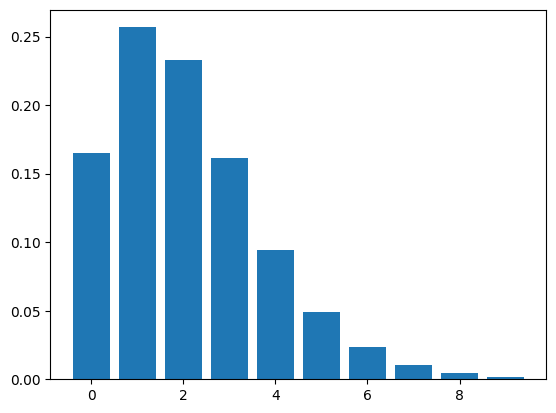

In [22]:
plt.bar(range(10), spst.nbinom.pmf(range(10), n=gammahat, p=alphahat_i/(alphahat_i+1)))
plt.show()

After the first observation, expected value jumps to 2.7, so it is moving toward the observation value of 5 from the original expectation of 0. Then after observing 1, it moves back somewhat toward an expected value 2.1. We can see the expectation get smaller with the new observations. This might because the increasing number of observation. The expectation adjust based on the new observations, like getting lower if the new observation suggest lower, and higher on the other side.